# From Actor Critic to Proximal Policy Gradient (PPO)
In the previous notebook, we learned basic policy gradient methods such as REINFORCE, REINFORCE with baseline, and Actor Critic. While they are widely used, there are two important downsides of these methods. Firstly, they are very sensitive to the step size. With supervised learning methods, even if we make a too large step at a certain iteration toward a bad direction, we can recover from there by using future samples. However, with reinforcement learning, if we make a too large step in a bad direction, our policy could be poor, which cannot collect experience including meaningful signals anymore. As a result, we never recover from that bad policy. 
But the critical problem is we don't know how the changes in parameter space affect the changes in policy space. For example, we can set a small step size in our optimizer to make sure that we only make a small update in our policy estimation parameters. However, the small parameter changes sometimes could result in a huge change in the policy (i.e. actions the agent takes). We don't have any guarantees within the policy space by constraining the optimizer learning rate. Therefore, these policy gradient methods are often unstable.
In this notebook, we will learn one important and very popular algorithm to solve this problem, Proximal Policy Gradient (PPO).
PPO uses a clipped objective function to make sure the small step size within a policy space. Thanks to this, it is also possible to train a model using multiple epochs with sampled data. With the normal policy gradient methods, if we train a model with multiple epochs, the model tends to take a too large step and the learning will be unstable. Thus, it is not easy to run multiple epochs. This data inefficiency is the second important downside of the three basic policy gradient methods. But the clipped objective made it possible to effectively use the sampled data through multiple epochs.

First, we will review the theory of PPO and then learn how we can change our implementation of REINFORCE with baseline from the previous notebook to use PPO.

## Clipped objective function

In REINFORCE with baseline algorithm we learned in this notebook, we used the below surrogate function to estimate the derivative in the direction of maximizing return.

\begin{align*}
\nabla L(\theta) &\propto \nabla \ln \pi(a_t|s_t,\theta) A_t \\
\end{align*}

where $A_t = (G_t-b(s_t))$ is the advantage of taking action $a_t$ at state $s_t$, $G_t$ is the total expected reward after time step $t$ (called return), and $b(s_t)$ is the prediction of the return expected at state $s_t$. We used this derivative estimate in gradient ascent to update our policy parameters

\begin{align*}
\theta_{t+1} &= \theta_t + \alpha \nabla \ln \pi(a_t|s_t,\theta) A_t \quad (\text{REINFORCE with baseline})
\end{align*}

To introduce PPO, we explore another form of the gradient estimate of the objective function as below:

\begin{align*}
\nabla L(\theta) &\propto \nabla \frac{\pi_{\theta}(a_t|s_t,\theta)}{\pi_{\theta old}(a_t|s_t,\theta)} A_t \\
\end{align*}

This form is introduced in the Conservative policy iteration algorithm in [this paper](https://people.eecs.berkeley.edu/%7Epabbeel/cs287-fa09/readings/KakadeLangford-icml2002.pdf). You might notice that the form is kind of similar to important sampling used in off-policy RL algorithm. The idea behind this form is very similar to the form used in REINFORCE with baseline. $\pi_{\theta old}$ is a policy before performing any updates, and optimization is performed to update the parameter in $\pi_{\theta}$. When $A_t$ is positive, we move the parameter $\theta$ in a direction increasing the probability of the current action. Conversely, when $A_t$ is negative, we move the parameter $\theta$ in a diction decreasing the probability of the current action. 

Let's denote the ratio and the objective function as follows:
\begin{align*}
r(\theta) = \frac{\pi_{\theta}(a_t|s_t,\theta)}{\pi_{\theta old}(a_t|s_t,\theta)}\\
\end{align*}

\begin{align*}
L(\theta) = r(\theta) A_t\\
\end{align*}

With this form, PPO uses a below clipped objective function

\begin{align*}
L^{CLIP}(\theta) = \mathbb{E}_{\pi} [min(r(\theta)A_t, clip(r(\theta), 1-\epsilon, 1+\epsilon) A_t)]
\end{align*}

In the next section, we digest how this objective function works. 

## Interpret clipped objective funcgtion

Let's think about what this clipped objective function does. We first focus on the clip term. 

Let's think about two cases. If $A_t$ is a positive value (left panel in the bottom figure), we would like to increase the probability of this action. In other words, we would like to make $r(\theta)>1$ by increasing the value of $\pi_{\theta}(a_t|s_t, \theta)$. But because of the clipping, we cannot make a too large step here. If we try to make a big step (which makes $r(\theta)>1+\epsilon$), the objective function value is clipped by $(1+\epsilon)*A_t$. This clipping makes sure that our policy does not change dramatically.
Similarly, when $A_t$ is a negative value (right panel in the bottom figure), we would like to decrease the probability of this action. Again, if we try to move too far from the current policy, the clipping function does its job. We can move at most $(1-\theta)A_t$ to reduce the probability of taking the current action but not more than that. 

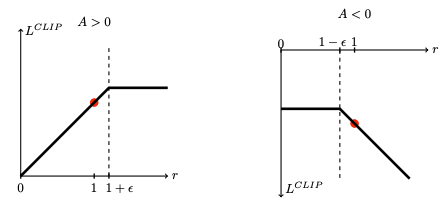

Next, let's think about the purpose of the $min$ term. The first term within the $min$ is simply the original form of objective function ($r(\theta)A_t$) introduced earlier. When our optimization algorithm moves the parameter in the right direction (i.e. increase the probability of positive advantage action or decrease the probability of negative advantage action), the first term is always equal to or larger than the second clip term. So the output will be always the same as the output from the clip term and we don't need this min term for these cases.

However, the $min$ term becomes crucial when the algorithm happens to choose a suboptimal direction due to the limited samples used for gradient estimation. For instance, consider a scenario where the advantage is positive, but the algorithm decides to reduce the probability of this action in the last epoch. If this happens, and the ratio $r(\theta) reaches the clipped value $1-\epsilon$, the clipped term produces zero gradients because the clipped objective value $(1-\epsilon)A_t$ does not involve parameter $\theta$. Thus, without $min$ term (i.e. relying solely on the clip term), the gradient will be zero, preventing the recovery from a bad policy update. In other words, no parameter update happens in this epoch and the policy stays at a bad policy. However, the gradient of the original objective function remains non-zero even in this case. Also, when the algorithm makes a bad update, the value of the original objective is equal to or smaller than the clipped value. Thus, the $min$ term allows recovery from the suboptimal update by using the gradient from the original function. 


## Algorithm overview of PPO   

We reviewed the theory of PPO so far. Next, let's learn the implementation. 

In the previous notebook, we learned the implementation of one of the basic policy gradient methods known as REINFORCE with baseline. REINFORCE with baseline uses advantage ($G_t-b_w(S_t)$) to estimate whether an action taken at a certain state results in a better return than the average return expected from that state. By using this advantage and the estimate of the policy network derivative, we iteratively increase the probability of good actions while decreasing the probability of taking bad actions.

Below is the pseudo-code of REINFORCE with baseline. If we can understand this, PPO only requires minor modifications from here. For the details of this algorithm, please refer to [this notebook]().

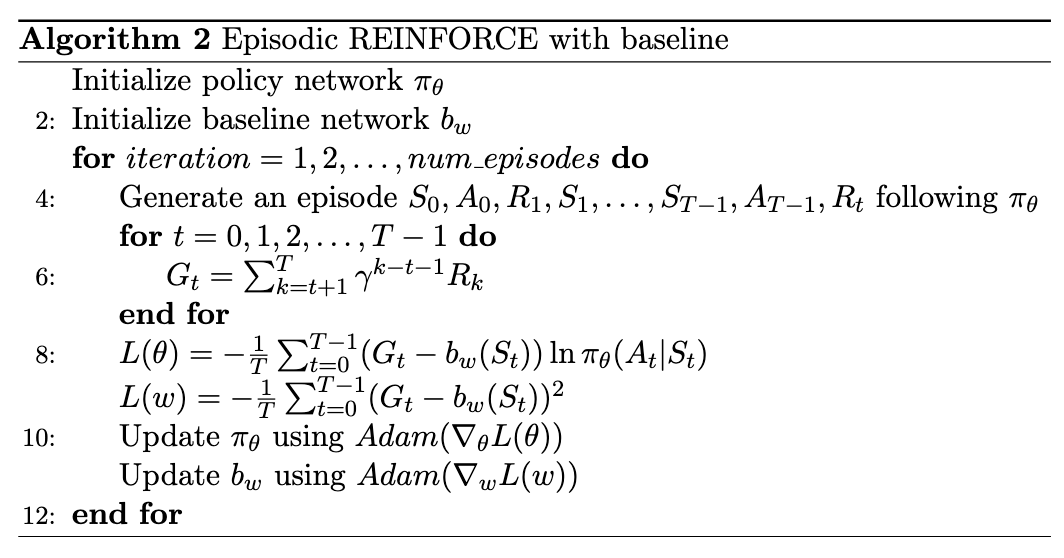

The above is the pseudo-code of REINFORCE with baseline. Below is the pseudo-code of PPO. There are two main differences between them.

Firstly, the objective function to update the policy network is different. While we use $L(\theta)$ in REINFORCE with baseline, we use the clipped objective function $L^{CLIP}(\theta)$ to update the parameters with PPO. The update for the baseline (value) network is the same between the two algorithms.

Secondly, with PPO, we update model parameters multiple times (i.e. train multiple epochs) with the same training episode. This was challenging with policy gradient algorithms because with more iterations, the policy deviates further from the original policy used to estimate the advantage values. This deviation (or reliance on inaccurate advantage estimates) results in instability of fitting. However, with PPO, we have a clipped objective function to ensure that we don't move too far from the current policy. The clip function enhances the efficiency of using training episode data by allowing multiple iterations.


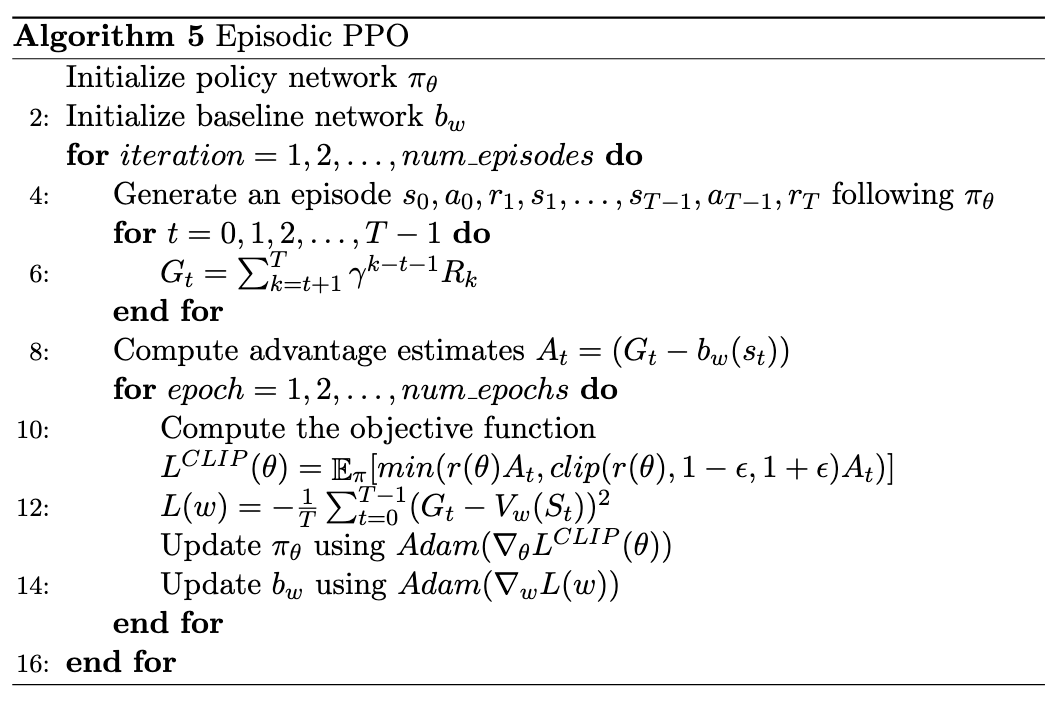

## Implementation of PPO

Now, let's implement PPO. Since two algorithms are very similar, we can use the same codes from the previous notebook in many parts. Below, I copied the same codes from this notebook (although there might be small differences such as variable names). To be consistent, let's use the same environment 'PoleCartPole-v0' in this notebook too.

In [1]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()
        
    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy
        
        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)


We use NeuralNet class to define policy and value networks. We use generate_single_episode function to generate training data by following the current policy. evaluate_policy function helps us to evaluate the performance of the current policy. There implementations are the same as REINFOREMENT with baseline.

Now, to implement PPO, we modify the implementation of train function. We will implement the for loop for epochs as well as the clipped objective as below.

In [3]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network on a single episode using REINFORCE with baseline
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(np.float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        V = value_net(states).to(device)
        
        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)
                
        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net
    
    

Okay, now we are ready to run PPO. Let's try running this algorithm. 

  0%|          | 0/5 [00:00<?, ?it/s]/Users/minaiyuki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/minaiyuki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Episode: 0
The avg. test reward for episode 0 is 18.4 with std of 6.814690014960328.
Episode: 50
The avg. test reward for episode 50 is 27.85 with std of 11.841769293479754.
Episode: 100
The avg. test reward for episode 100 is 32.0 with std of 8.179242018671413.
Episode: 150
The avg. test reward for episode 150 is 41.7 with std of 9.333273809334.
Episode: 200
The avg. test reward for episode 200 is 124.55 with std of 14.654265590605352.
Episode: 250
The avg. test reward for episode 250 is 121.25 with std of 18.08003042032839.
Episode: 300
The avg. test reward for episode 300 is 170.5 with std of 21.532533524878115.
Episode: 350
The avg. test reward for episode 350 is 200.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 174.8 with std of 19.497692171126307.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 180.75 with std of 40.620038158524665.
Episode: 550
The avg. test reward for epis

 20%|██        | 1/5 [00:45<03:02, 45.64s/it]

Episode: 0
The avg. test reward for episode 0 is 16.8 with std of 4.202380277890139.
Episode: 50
The avg. test reward for episode 50 is 19.75 with std of 7.272379253036794.
Episode: 100
The avg. test reward for episode 100 is 157.15 with std of 44.10926773366341.
Episode: 150
The avg. test reward for episode 150 is 196.1 with std of 13.453252394867198.
Episode: 200
The avg. test reward for episode 200 is 196.9 with std of 13.512586724976089.
Episode: 250
The avg. test reward for episode 250 is 200.0 with std of 0.0.
Episode: 300
The avg. test reward for episode 300 is 199.65 with std of 1.5256146302392357.
Episode: 350
The avg. test reward for episode 350 is 200.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 133.1 with std of 51.15261479142587.
Episode: 550
The avg. test reward for episode 550 is 178.5 with std 

 40%|████      | 2/5 [01:35<02:24, 48.05s/it]

Episode: 0
The avg. test reward for episode 0 is 24.85 with std of 11.551082200382785.
Episode: 50
The avg. test reward for episode 50 is 20.5 with std of 9.063663718386731.
Episode: 100
The avg. test reward for episode 100 is 50.7 with std of 11.437219941926447.
Episode: 150
The avg. test reward for episode 150 is 107.6 with std of 5.219195340279955.
Episode: 200
The avg. test reward for episode 200 is 188.0 with std of 22.126906697502932.
Episode: 250
The avg. test reward for episode 250 is 186.95 with std of 21.73585747100859.
Episode: 300
The avg. test reward for episode 300 is 199.45 with std of 1.9868316486305524.
Episode: 350
The avg. test reward for episode 350 is 196.35 with std of 7.384273830242212.
Episode: 400
The avg. test reward for episode 400 is 163.2 with std of 17.060480649735517.
Episode: 450
The avg. test reward for episode 450 is 189.75 with std of 17.761967796390127.
Episode: 500
The avg. test reward for episode 500 is 194.2 with std of 20.2894061026931.
Episode: 

 60%|██████    | 3/5 [02:21<01:34, 47.29s/it]

Episode: 0
The avg. test reward for episode 0 is 25.05 with std of 9.074552330556036.
Episode: 50
The avg. test reward for episode 50 is 71.45 with std of 32.210984151372955.
Episode: 100
The avg. test reward for episode 100 is 34.85 with std of 6.215102573570287.
Episode: 150
The avg. test reward for episode 150 is 87.85 with std of 30.313816981699947.
Episode: 200
The avg. test reward for episode 200 is 84.0 with std of 32.934784043621725.
Episode: 250
The avg. test reward for episode 250 is 98.6 with std of 40.72149309639812.
Episode: 300
The avg. test reward for episode 300 is 188.25 with std of 19.59049514432956.
Episode: 350
The avg. test reward for episode 350 is 195.35 with std of 11.235101245649725.
Episode: 400
The avg. test reward for episode 400 is 170.95 with std of 26.856051459587277.
Episode: 450
The avg. test reward for episode 450 is 150.9 with std of 26.233375688233494.
Episode: 500
The avg. test reward for episode 500 is 186.7 with std of 24.06678208651917.
Episode: 

 80%|████████  | 4/5 [03:06<00:46, 46.43s/it]

Episode: 0
The avg. test reward for episode 0 is 21.65 with std of 9.665790190150002.
Episode: 50
The avg. test reward for episode 50 is 39.0 with std of 19.128512749296533.
Episode: 100
The avg. test reward for episode 100 is 40.55 with std of 13.447955234904674.
Episode: 150
The avg. test reward for episode 150 is 91.55 with std of 22.041948643438946.
Episode: 200
The avg. test reward for episode 200 is 177.6 with std of 19.757024067404483.
Episode: 250
The avg. test reward for episode 250 is 132.25 with std of 20.52528927932564.
Episode: 300
The avg. test reward for episode 300 is 198.25 with std of 5.512485827646181.
Episode: 350
The avg. test reward for episode 350 is 192.3 with std of 9.690717207719974.
Episode: 400
The avg. test reward for episode 400 is 199.95 with std of 0.21794494717703367.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 189.55 with std of 26.375130331431535.
Episode: 550
The avg

100%|██████████| 5/5 [03:53<00:00, 46.67s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

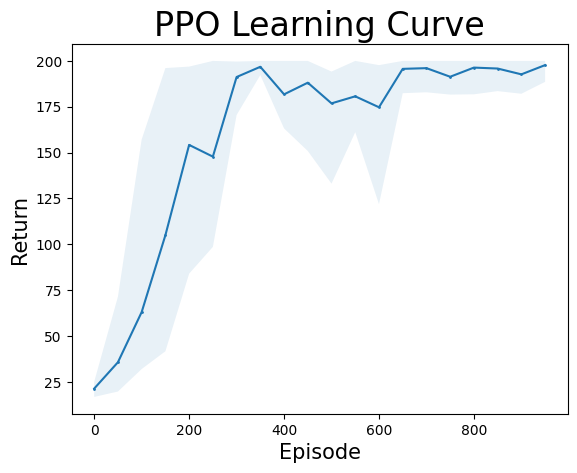

In [5]:
# Define parameter values
env_name = 'CartPole-v0'
num_train_ite = 1000
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4

policy_lr = 5e-4 # policy network's learning rate 
baseline_lr = 1e-4

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

    

As expected, the model performed better as training progresses and reached the performance upper bound (200 return) around 300 episodes! 

The above PPO implementation seems working but there are some techniques commonly used to improve the performance. In the below implementation, I incooporated three such techniques.
- Normalize advantage values to stabilize learning
- Add entropy term in policy loss function to encourage exploration
- Use multiple episodes at each iteration to stablize learning (or increase the amount of training data at each iteration)


In [7]:
def compute_Gs_per_episode(batch_rews, gamma):
    # The rewards-to-go (rtg) per episode per batch to return
    batch_rtgs = []
    
    # Iterate through each episode backwards to maintain same order in batch_rtgs
    for ep_rews in reversed(batch_rews):
        discounted_reward = 0 # Discounted reward so far
        
        for rew in reversed(ep_rews):
            discounted_reward = rew + discounted_reward * gamma
            batch_rtgs.insert(0, discounted_reward)
            
    # Convert the rewards-to-go into a tensor
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

    return batch_rtgs


def generate_multiple_episodes(env, policy_net, max_batch_size=500):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    i = 0
    
    while i < max_batch_size:
        state, _ = env.reset()
        reward_per_epi = []
        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
            # action = np.argmax(probs.detach().numpy()) # greedy
            
            # compute the log_prob to use this in parameter update
            log_prob = torch.log(probs.squeeze(0)[action])
            
            # append values
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            
            # take a selected action
            state, reward, terminated, truncated, _ = env.step(action)
            reward_per_epi.append(reward)
            
            i += 1

            if terminated | truncated:
                break
        rewards.append(reward_per_epi)
        
    return states, actions, rewards, log_probs


def train_PPO_multi_epi(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, max_batch_size=100, entropy_coef=0.1, normalize_ad=True, add_entropy=True):
    """
    Trains the policy network on a single episode using REINFORCE with baseline
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_multiple_episodes(env, policy_net, max_batch_size=max_batch_size)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(np.float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step in each episode
    Gs = compute_Gs_per_episode(rewards, gamma).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
    if normalize_ad:
        A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10) # Normalize advantages
        
    for _ in range(num_epochs):
        V = value_net(states).to(device)
        
        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)
                
        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # Caluculate entropy
        entropy = 0
        if add_entropy:
            entropy = torch.distributions.Categorical(probs).entropy()
            entropy = torch.tensor([[e] for e in entropy])
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2) - entropy_coef * entropy).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()        
        
    return policy_net, value_net

  0%|          | 0/5 [00:00<?, ?it/s]/Users/minaiyuki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/minaiyuki/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Episode: 0
The avg. test reward for episode 0 is 26.05 with std of 15.599599353829573.
Episode: 50
The avg. test reward for episode 50 is 131.7 with std of 49.51878431464165.
Episode: 100
The avg. test reward for episode 100 is 142.75 with std of 42.84142271213691.
Episode: 150
The avg. test reward for episode 150 is 146.55 with std of 48.558701588901656.
Episode: 200
The avg. test reward for episode 200 is 185.85 with std of 32.906344373084046.
Episode: 250
The avg. test reward for episode 250 is 190.35 with std of 31.78564927762213.
Episode: 300
The avg. test reward for episode 300 is 186.95 with std of 30.249752065099642.
Episode: 350
The avg. test reward for episode 350 is 159.05 with std of 30.929718718410616.
Episode: 400
The avg. test reward for episode 400 is 194.8 with std of 22.6662745064115.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward 

 20%|██        | 1/5 [00:54<03:38, 54.54s/it]

Episode: 0
The avg. test reward for episode 0 is 21.4 with std of 6.351377803280167.
Episode: 50
The avg. test reward for episode 50 is 89.55 with std of 33.532782467311.
Episode: 100
The avg. test reward for episode 100 is 127.9 with std of 25.317780313447702.
Episode: 150
The avg. test reward for episode 150 is 185.6 with std of 42.86070461390013.
Episode: 200
The avg. test reward for episode 200 is 125.6 with std of 28.489296235603998.
Episode: 250
The avg. test reward for episode 250 is 198.35 with std of 3.5535193822462827.
Episode: 300
The avg. test reward for episode 300 is 192.65 with std of 18.426272004939033.
Episode: 350
The avg. test reward for episode 350 is 199.05 with std of 2.67348087705897.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 194.9 with std of 22.230384612057435.
Episode: 500
The avg. test reward for episode 500 is 108.45 with std of 10.952054601763086.
Episode: 550
The avg. te

 40%|████      | 2/5 [01:47<02:41, 53.73s/it]

Episode: 0
The avg. test reward for episode 0 is 22.1 with std of 13.645145656972666.
Episode: 50
The avg. test reward for episode 50 is 179.9 with std of 41.861557543885056.
Episode: 100
The avg. test reward for episode 100 is 85.2 with std of 27.936714194765283.
Episode: 150
The avg. test reward for episode 150 is 200.0 with std of 0.0.
Episode: 200
The avg. test reward for episode 200 is 136.65 with std of 39.88016424238998.
Episode: 250
The avg. test reward for episode 250 is 152.3 with std of 25.302371430362015.
Episode: 300
The avg. test reward for episode 300 is 163.35 with std of 43.538804531130616.
Episode: 350
The avg. test reward for episode 350 is 194.45 with std of 16.240304800095345.
Episode: 400
The avg. test reward for episode 400 is 186.7 with std of 14.940214188558341.
Episode: 450
The avg. test reward for episode 450 is 190.6 with std of 11.512601791080938.
Episode: 500
The avg. test reward for episode 500 is 183.25 with std of 10.572960796295426.
Episode: 550
The av

 60%|██████    | 3/5 [02:41<01:47, 53.74s/it]

Episode: 0
The avg. test reward for episode 0 is 24.2 with std of 10.351811435686027.
Episode: 50
The avg. test reward for episode 50 is 173.75 with std of 38.870136351703216.
Episode: 100
The avg. test reward for episode 100 is 156.45 with std of 42.969145907267.
Episode: 150
The avg. test reward for episode 150 is 199.95 with std of 0.2179449471770337.
Episode: 200
The avg. test reward for episode 200 is 184.8 with std of 31.927417684491807.
Episode: 250
The avg. test reward for episode 250 is 148.7 with std of 25.157702597812865.
Episode: 300
The avg. test reward for episode 300 is 164.1 with std of 14.902684321960255.
Episode: 350
The avg. test reward for episode 350 is 167.95 with std of 14.343901142994538.
Episode: 400
The avg. test reward for episode 400 is 200.0 with std of 0.0.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward for episode 550 

 80%|████████  | 4/5 [03:36<00:54, 54.33s/it]

Episode: 0
The avg. test reward for episode 0 is 21.45 with std of 11.34669555421313.
Episode: 50
The avg. test reward for episode 50 is 115.75 with std of 41.40637028284416.
Episode: 100
The avg. test reward for episode 100 is 199.35 with std of 2.833284313301438.
Episode: 150
The avg. test reward for episode 150 is 185.2 with std of 32.085199079949625.
Episode: 200
The avg. test reward for episode 200 is 175.25 with std of 41.15807940125487.
Episode: 250
The avg. test reward for episode 250 is 192.95 with std of 21.516214815808098.
Episode: 300
The avg. test reward for episode 300 is 173.05 with std of 31.933485559832018.
Episode: 350
The avg. test reward for episode 350 is 200.0 with std of 0.0.
Episode: 400
The avg. test reward for episode 400 is 123.6 with std of 18.042727066604982.
Episode: 450
The avg. test reward for episode 450 is 189.45 with std of 37.5052996255196.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward f

100%|██████████| 5/5 [04:31<00:00, 54.28s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

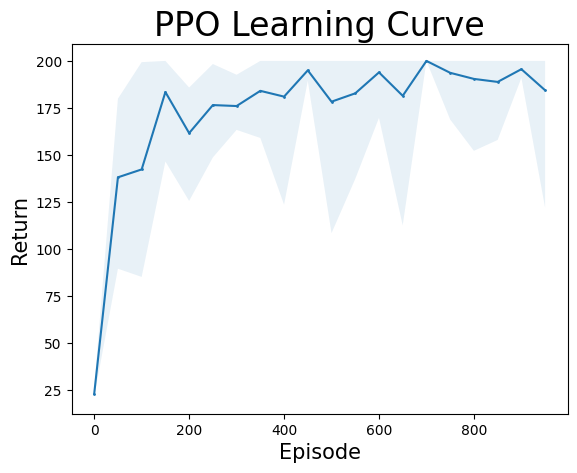

In [8]:
# Define parameter values
returns = np.zeros((num_seeds, eval_epi_index))
max_batch_size = 100
entropy_coef = 0.1
normalize_ad = True
add_entropy = True

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO_multi_epi(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma, max_batch_size=max_batch_size, entropy_coef=entropy_coef, normalize_ad=normalize_ad, add_entropy=add_entropy)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

    
# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)


## Summary

In this notebook, we reviewed the theory and implementation of PPO. PPO introduced the clipped objective function to constrain a step we move within a policy space at each iteration. This update lets us train a model for multiple epochs using the same training data (i.e. improve data efficiency). Also, as we saw through the above implementation, the implementation of PPO is very simple and easy. Because of these, although it was introduced in 2017, PPO is still widely used in RL projects. I hope you learned something new and useful from this notebook :)


## Ref
- Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). Proximal policy optimization algorithms.
- Schulman, J., Levine, S., Abbeel, P., Jordan, M., & Moritz, P. (2015, June). Trust region policy optimization. 
- Coding PPO from Scratch with PyTorch by Eric Yang Yu
    - https://medium.com/analytics-vidhya/coding-ppo-from-scratch-with-pytorch-part-1-4-613dfc1b14c8
